# Some initial stuff

In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization!
import tensorflow as tf
from LayersRagged import RaggedGravNet, RaggedConstructTensor
import DeepJetCore.DataCollection as dc
from model_overfitting_king import OverfittingKing
from model_overfitting_queen import OverfittingQueen
from model_dgcnn_alpha import DgcnnModelAlpha
from model_dgcnn_beta import DgcnnModelBeta


import os
from object_condensation import evaluate_loss
import uuid
import time
import pickle
from object_condensation import remove_zero_length_elements_from_ragged_tensors
import argparse
import numpy as np


data = dc.DataCollection('/eos/cms/store/cmst3/group/hgcal/CMG_studies/pepr/50_part_sample/testdata/dataCollection.djcdc')
data.setBatchSize(10000)
data.invokeGenerator()
nbatches = data.generator.getNBatches()
print("The data has",nbatches,"batches.")
gen = data.generatorFunction()
batch = xbatch = gen.next()

ragged_constructor = RaggedConstructTensor()


print("Ready")




setGPU: Setting GPU to: 1


/usr/share/DJC/DeepJetCore/__init__.py:14: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py"

('The data has', 3995, 'batches.')
Ready


In [2]:
input_s = batch[0][0]
input_s_spatial = tf.concat((input_s[:,1][..., tf.newaxis],input_s[:,2][..., tf.newaxis],input_s[:,7][..., tf.newaxis]), axis=-1)
print(tf.reduce_min(input_s_spatial, axis=0).numpy(), tf.reduce_max(input_s_spatial, axis=0).numpy())


(array([  -3.075902 ,   -1.1457305, -513.149    ], dtype=float32), array([  3.0765448,   1.1007665, 513.149    ], dtype=float32))


# This will reload the model

Find the training id and put it there and also put the correct model. It will print number of iterations quicky skim through it to see if the correct model is getting loaded.

In [105]:
# Overfitting one
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)


t=10

lovasz = False

if t==1:
    my_model = OverfittingKing()
    trainid = '7bc6588318564d82816a85bf9465c1b3'
elif t==2:
    my_model = OverfittingQueen()
    trainid = '9e06cee9d17048cc9d0c8d7bff2b5e99'
elif t==3:
    my_model = DgcnnModelAlpha()
    trainid = '84ef31379527430c9bbd61fffa2f7f41'
elif t==4:
    my_model = DgcnnModelAlpha()
    trainid = 'object_overfitting_dgcnn_alpha_2'
elif t==5:
    my_model = DgcnnModelBeta(training=False)
    trainid = 'dgcnn_beta_with_batch_normalization_normal'
elif t==6:
    lovasz = True
    my_model = DgcnnModelAlpha(clustering_space_dimensions=(5 if lovasz else 2))
    trainid = 'lovasz_overfitting_dgcnn_alpha_1'
elif t==7:
    lovasz = True
    my_model = DgcnnModelAlpha(clustering_space_dimensions=(5 if lovasz else 2))
    trainid = 'lovasz_normal_dgcnn_alpha_1'
elif t==8:
    lovasz = True
    my_model = OverfittingKing(clustering_dims=(5 if lovasz else 2))
    trainid = 'lovasz_overfitting_king_alpha_1'
elif t==9:
    my_model = DgcnnModelAlpha()
    trainid = 'comparison_loss_both'
elif t==10:
    my_model = DgcnnModelAlpha()
    trainid = 'normal_training_loopy_dgcnn'
else:
    0/0

print(my_model)

# Non overfitting
# trainid = '5bdeef1e6b0c4bf19ca77b93028978ea'


checkpoints_path = 'train_data/%s/checkpoints' % trainid



checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=my_model)
manager = tf.train.CheckpointManager(
    checkpoint, directory=checkpoints_path, max_to_keep=5)
status = checkpoint.restore(manager.latest_checkpoint)

print("Trained for", optimizer.iterations.numpy(),"iterations")
print(status)

('Trained for', 45701, 'iterations')


In [106]:
# batch = xbatch = gen.next()

clustering_space, beta_values = my_model.call(xbatch[0][0], xbatch[0][1])
y_data, row_splits = ragged_constructor((xbatch[1][0], xbatch[1][1]))
y_data = y_data[:, 0]

beta_values = beta_values.numpy()
# print(beta_values[beta_values>0.3])

# print(len(beta_values[beta_values>0.3]))


np.set_printoptions(threshold=np.inf)
# print(repr(np.sort(beta_values)))


# print("Hello wohooo")

sum = 0
for i in range(len(row_splits) - 1):
    x_data_this = y_data[row_splits[i]:row_splits[i+1]].numpy()
    u = np.unique(x_data_this)
#     print(u)
    sum+= len(u)


# print("Unique showers", sum)

In [107]:
def plot_shower(x_data, clustering_space, classes):
    x_data_this_x = x_data[:, 1]
    x_data_this_y = x_data[:, 2]
    x_data_this_z = x_data[:, 7]
    x_data_this_energy = x_data[:, 0]    
    
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(x_data_this_z, x_data_this_x, x_data_this_y, c = classes, s=x_data_this_energy*10, cmap=plt.get_cmap('gist_rainbow'))
    plt.xlabel('z')
    plt.ylabel('phi')
    ax.set_zlabel('eta')
    
    plt.title('Shower - size represents energy (linear)')
    plt.show()
    
def plot_clustering_space(this_clustering_space, this_classes):
    plt.figure()
    plt.scatter(this_clustering_space[:,0].numpy(), this_clustering_space[:,1].numpy(),s=0.8, c=this_classes.numpy(), cmap=plt.get_cmap('gist_rainbow'))
    plt.xlabel('Clustering dimension 1')
    plt.ylabel('Clustering dimension 2')
    plt.show()
    
    
def plot_clustering_space_lovasz(x_data, clustering_space, classes):
    fig = plt.figure()
    ax = Axes3D(fig)
    
    min_value = tf.convert_to_tensor([-4., -4., -600])[tf.newaxis, ...]
    max_value = tf.convert_to_tensor([4, 4, +600.])[tf.newaxis, ...]

    
    x_data_this_x = x_data[:, 1][..., tf.newaxis]
    x_data_this_y = x_data[:, 2][..., tf.newaxis]
    x_data_this_z = x_data[:, 7][..., tf.newaxis]
    x_data_spatial = tf.concat((x_data_this_x, x_data_this_y, x_data_this_z), axis=-1)
    xs = x_data_spatial = (x_data_spatial - min_value)/ (max_value - min_value)
    
    unit_displacement = tf.reduce_sum(tf.pow(clustering_space, 2), axis=-1)
    cs = clustering_space
    
    ax.scatter(xs[:,2]+cs[:,2], xs[:,0]+cs[:,0], xs[:,1]+cs[:,1], c = classes, s=0.8, cmap=plt.get_cmap('gist_rainbow'))
    plt.xlabel('clustering dimension 1')
    plt.ylabel('clustering dimension 2')
    ax.set_zlabel('clustering dimension 3')


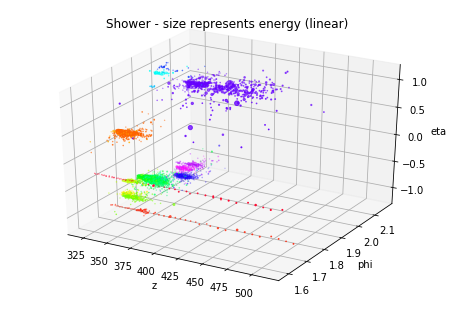

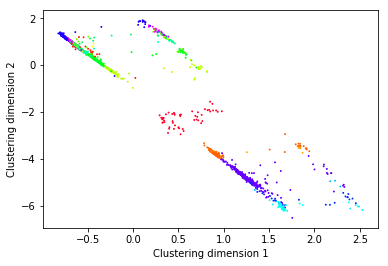

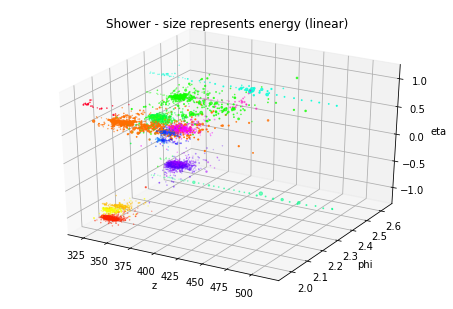

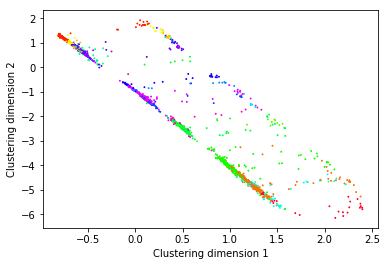

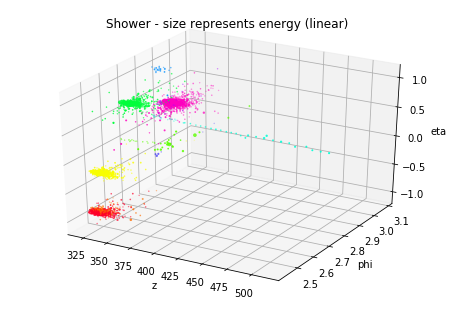

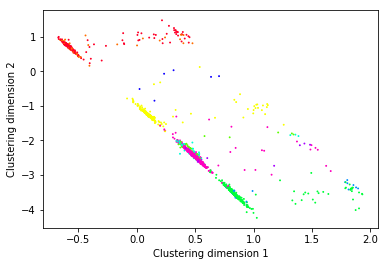

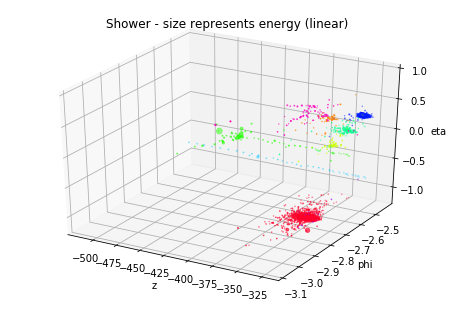

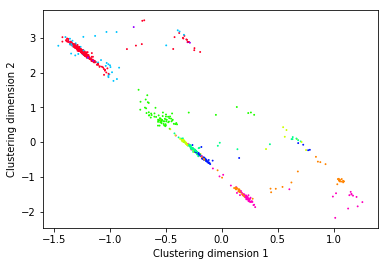

In [108]:
clustering_space, beta_values = my_model.call(xbatch[0][0], xbatch[0][1])



for i in range(4):
    id = i
    this_clustering_space = clustering_space[row_splits[id]:row_splits[id+1]]
    this_betas = beta_values[row_splits[id]:row_splits[id+1]]
    this_classes = y_data[row_splits[id]:row_splits[id+1]]
    this_x = xbatch[0][0][row_splits[id]:row_splits[id+1]]
    
    x_data_this_energy = this_x[:, 0]
#     plt.hist(x_data_this_energy)
    s = (x_data_this_energy > 0.5)*0.8 + (x_data_this_energy < 0.5)*0.1
    
    
    this_clustergin_space_high_betas = this_clustering_space[this_betas>0.03]
    
    
    plot_shower(this_x, this_clustering_space, this_classes)
    if lovasz:
        plot_clustering_space_lovasz(this_x, this_clustering_space, this_classes)
    else:
        plot_clustering_space(this_clustering_space, this_classes)
    
    

# 

In [100]:
print("Hello world")

Hello world
